# install and import packages

In [1]:
!pip install numpy pyDOE2 scikit-learn lime anchor-exp tabulate river pytest

Defaulting to user installation because normal site-packages is not writeable


# Experiments 

## Functions

In [174]:
def violations_fn(x):
    x = x.astype(float)
    d = np.digitize(x, [0, 5, float('inf')],
                    right=True).astype('|S128')
    return map_array_values(d, {'0': 'NO', '1': '1 to 5', '2': 'More than 5'})

def priors_fn(x):
    x = x.astype(float)
    d = np.digitize(x, [-1, 0, 5, float('inf')],
                    right=True).astype('|S128')
    return map_array_values(d, {'0': 'UNKNOWN', '1': 'NO', '2': '1 to 5', '3': 'More than 5'})

transformations = {
    0: lambda x: ['Black', 'White'][x],         
    1: lambda x: ['No', 'Yes'][x],              
    2: lambda x: ['No', 'Yes'][x],              
    3: lambda x: ['No', 'Yes'][x],              
    4: lambda x: ['No', 'Married'][x],          
    5: lambda x: ['No', 'Yes'][x],              
    6: lambda x: ['No', 'Yes'][x],              
    7: lambda x: ['No', 'Yes'][x],              
    8: lambda x: ['No', 'Yes'][x],              
    9: lambda x: ['Female', 'Male'][x],
    10: lambda x: x,
    11: lambda x: x,
    12: lambda x: x,                                  
    13: lambda x: x,
    14: lambda x: x,
    15: lambda x: x,
    16: lambda x: ['No more crimes', 'Re-arrested  '][x]            
}
def my_transformations(i, x):
    trg = transformations[i](x)
    if type(trg) is str:
        trg = trg + ' (%d)' % x
    return trg 

In [215]:
import utils

from tabulate import tabulate
import time
import csv

def get_trg_sample(index, dataset, dataset_name, dataset_folder):
    print('Index: ', index)
    raw_dataset = utils.load_dataset(
        dataset_name, balance=True, dataset_folder=dataset_folder, discretize=False)
    trg = dataset.test[index]
    label = dataset.labels_test[index]
    
    int_list = list(int(x) for x in raw_dataset.test[index])
    str_list = [my_transformations(i, x) for i, x in enumerate(int_list)]
    trg_data = list(zip(raw_dataset.feature_names, str_list))

    print('Prediction:', raw_dataset.class_names[rf.predict(trg.reshape(1, -1))[0]])
    print('True:      ', raw_dataset.class_names[dataset.labels_test[index]])
    print(tabulate(trg_data))
    f = open('img/%s/%05d-instance.txt' % (dataset_name, index), 'w')
    f.write(tabulate(trg_data))
    f.close()
    with open('img/%s/%05d-instance.csv' % (dataset_name, index), 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows([['feature', 'value']])
        writer.writerows(trg_data)
        writer.writerows([['Recidivism', my_transformations(16, label)]])
    return trg, label

In [266]:
import explanation
import lime_tabular

def lime_original(trg, pred_label):
    lime_explainer = lime_tabular.LimeTabularExplainer(
        dataset.train,
        feature_names=dataset.feature_names,
        class_names=dataset.class_names,
        discretize_continuous=False)
    lime_exp = lime_explainer.explain_instance(
        trg, rf.predict_proba, num_features=5, top_labels=1)
    # lime_exp.show_in_notebook(show_table=True, show_all=True)
    weights = [0] * len(dataset.feature_names)
    for t in lime_exp.local_exp[pred_label]:
        weights[t[0]] = t[1] * (pred_label * 2 - 1)
    plot_weights(weights, dataset.feature_names)

In [177]:
from anchor import anchor_tabular

def anchor_original(trg, threshold=0.85):
    anchor_explainer = anchor_tabular.AnchorTabularExplainer(
        dataset.class_names,
        dataset.feature_names,
        dataset.train,
        dataset.categorical_names)
    anchor_exp = anchor_explainer.explain_instance(
        trg, rf.predict, threshold)

    print('Threshold:  %.2f' % threshold)
    # print('Prediction:', anchor_explainer.class_names[rf.predict(trg.reshape(1, -1))[0]])
    print('Anchor:     %s' % (' AND '.join(anchor_exp.names())))
    print('Precision:  %.2f' % anchor_exp.precision())
    print('Coverage:   %.2f' % anchor_exp.coverage())

Index:  653
Prediction: b'1'
True:       b'1'
----------------------  ---------
Race                    White (1)
Alcohol                 Yes (1)
Junky                   Yes (1)
Supervised Release      Yes (1)
Married                 No (0)
Felony                  No (0)
WorkRelease             No (0)
Crime against Property  Yes (1)
Crime against Person    No (0)
Gender                  Male (1)
Priors                  1
YearsSchool             8
PrisonViolations        0
Age                     17
MonthsServed            10
----------------------  ---------
['Crime against Property = 1']
['Crime against Property = 1', 'Priors = 1']
['Priors = 1', 'Crime against Property = 1', 'PrisonViolations = 0', 'Supervised Release = 1']


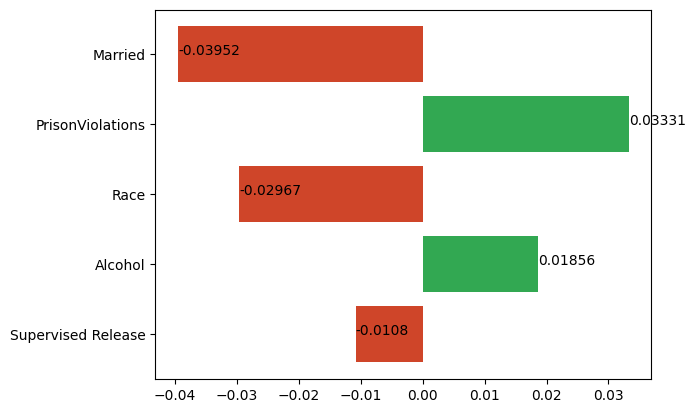

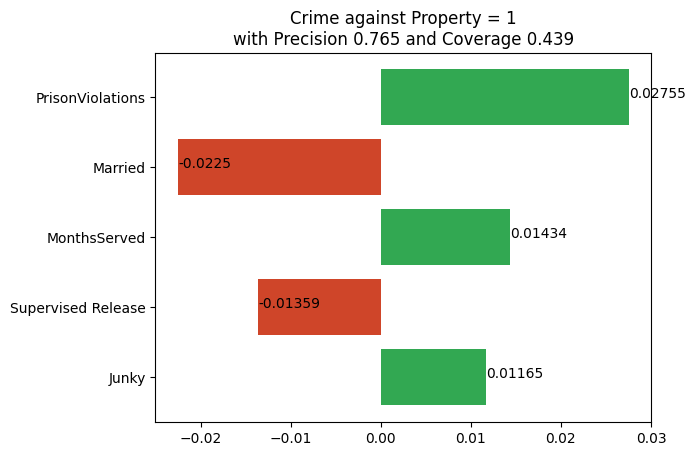

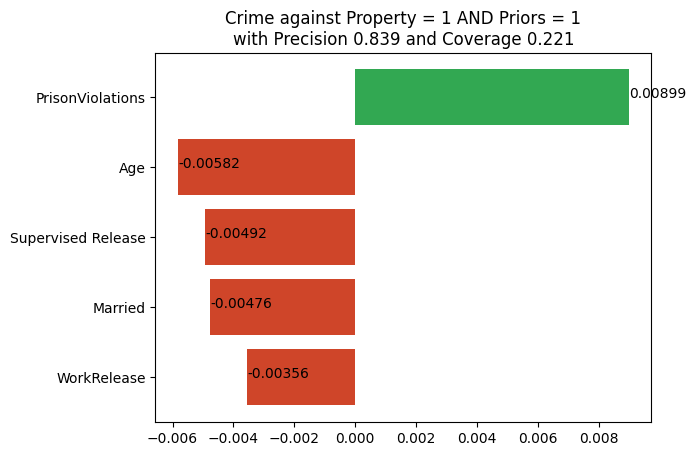

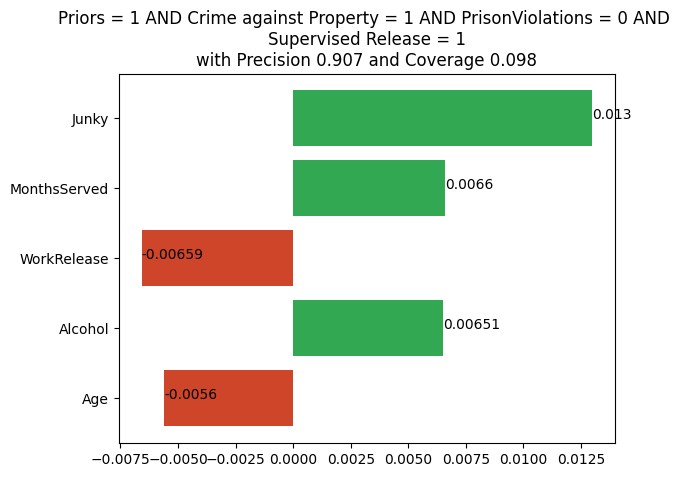

In [340]:
import my_anchor_base
import my_anchor_tabular

# display
import matplotlib.pyplot as plt
    
import importlib
importlib.reload(my_anchor_base)
importlib.reload(my_anchor_tabular)

def new_lime(trg, dataset, threshold=0.90):
    anchor_explainer = my_anchor_tabular.AnchorTabularExplainer(
        dataset.class_names,
        dataset.feature_names,
        dataset.train,
        dataset.categorical_names)
    anchor_exp, surrogate_model = anchor_explainer.explain_instance(trg, rf.predict, threshold=threshold)
    
    names = anchor_exp.names()
    multiline_names = []
    max_i = int(len(names) / 3)
    for i in range(max_i):
        triple = [names[i * 3], names[i * 3 + 1], names[i * 3 + 2]]
        multiline_names.append(' AND '.join(triple))
    if len(names) != max_i* 3:
        multiline_names.append(' AND '.join(names[max_i * 3:]))
    print(names)
    plot_weights(
        list(surrogate_model['LogisticRegression'].weights.values()),
        dataset.feature_names,
        ' AND \n'.join(multiline_names),
        anchor_exp.precision(),
        anchor_exp.coverage()
    )
    
i = random.randint(10, dataset.test.shape[0])
# 449, 568
# i = 568
# i = 479
# i = 640
i = 653
trg, trg_label = get_trg_sample(i, dataset, dataset_name, dataset_folder)
# 101
# 599, 640
if i != 599:
    lime_original(trg, rf.predict([dataset.test[i]])[0])
    img_file = 'img/%s/%05d-LIME.png' % (dataset_name, i)
    plt.savefig(img_file, bbox_inches='tight')
    for t in [0.70, 0.80, 0.90]:
        new_lime(trg, dataset, threshold=t)
        img_file = 'img/%s/%05d-%03d.png' % (dataset_name, i, t * 100)
        plt.savefig(img_file, bbox_inches='tight')

In [211]:
def plot_weights(weights, feature_names, anchor=None, precision=None, coverage=None):
    features = feature_names
    values = weights
    abs_values = [abs(x) for x in values]
    _, sorted_features, sorted_values = zip(*sorted(zip(abs_values, features, values), reverse=False)[-5:])
    plt.figure()
    color = ['#32a852' if sorted_values[i] > 0 else '#cf4529' for i in range(len(sorted_values))]
    plt.barh(sorted_features, sorted_values, color=color)
    anchor_str = ''
    
    if anchor != None:
        plt.title('%s\nwith Precision %.3f and Coverage %.3f' % (anchor, precision, coverage))
    for i in range(len(sorted_features)):
        plt.text(sorted_values[i], sorted_features[i], round(sorted_values[i], 5))
    plt.show


## Generating Explanations

In [214]:
import utils
import os

dataset_folder = 'datasets/'
dataset_name = 'recidivism'
# dataset_name = 'adult'
# dataset_name = 'diabetes'
# dataset_name = 'default'
# dataset_name = 'lending'

dataset = utils.load_dataset(
    dataset_name, balance=True, dataset_folder=dataset_folder, discretize=True)

In [17]:
import sklearn.ensemble

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)

rf.fit(dataset.train, dataset.labels_train)
print('Train', sklearn.metrics.accuracy_score(
    dataset.labels_train, rf.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(
    dataset.labels_test, rf.predict(dataset.test)))

Train 0.9954182484618406
Test 0.650261780104712


In [20]:
print(dataset.train.shape[0])
print(dataset.test.shape[0])
print(dataset.train.shape[0] + dataset.test.shape[0])

7639
955
8594


In [329]:
import numpy as np
import random

importlib.reload(my_anchor_base)
importlib.reload(my_anchor_tabular)

# 265, 266, 599
i = random.randint(10, dataset.test.shape[0])
# i = 266
i = 599
# adult
# 730, 956, 1196, 1522
# i = 1443 # --- Capital Gain = 2

# recidivism 
# 444, 542
# i = 444
# i = 542
trg, trg_label = get_trg_sample(i, dataset, dataset_name, dataset_folder)

Index:  599
Prediction: b'1'
True:       b'0'
----------------------  ---------
Race                    Black (0)
Alcohol                 No (0)
Junky                   Yes (1)
Supervised Release      No (0)
Married                 No (0)
Felony                  Yes (1)
WorkRelease             No (0)
Crime against Property  No (0)
Crime against Person    No (0)
Gender                  Male (1)
Priors                  2
YearsSchool             8
PrisonViolations        2
Age                     24
MonthsServed            16
----------------------  ---------


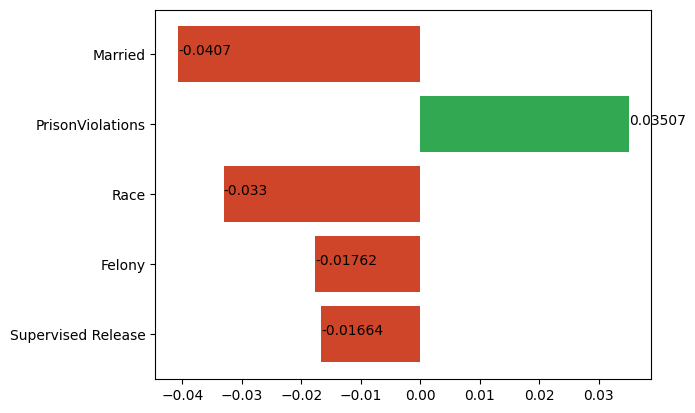

In [330]:
lime_original(trg, rf.predict([dataset.test[i]])[0])
img_file = 'img/%s/%05d-LIME.png' % (dataset_name, i)
plt.savefig(img_file, bbox_inches='tight')

['Junky = 1']
['PrisonViolations = 2', 'Race = 0']
['PrisonViolations = 2', 'Race = 0', 'Married = 0', 'Priors = 2', 'Crime against Person = 0', 'Alcohol = 0', 'Gender = 1', 'Crime against Property = 0', 'WorkRelease = 0', 'Felony = 1']


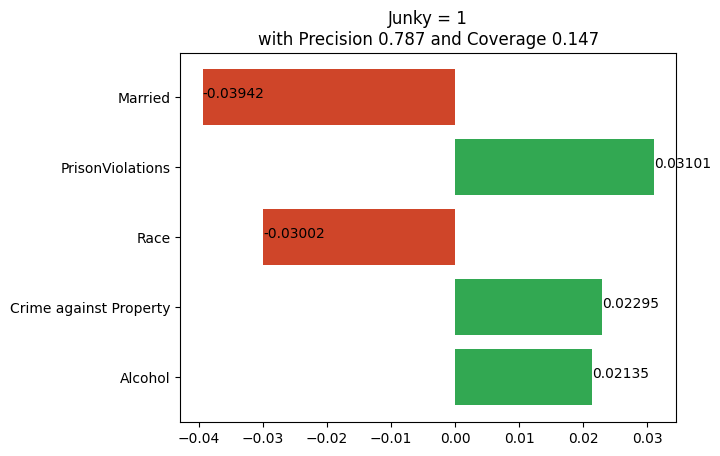

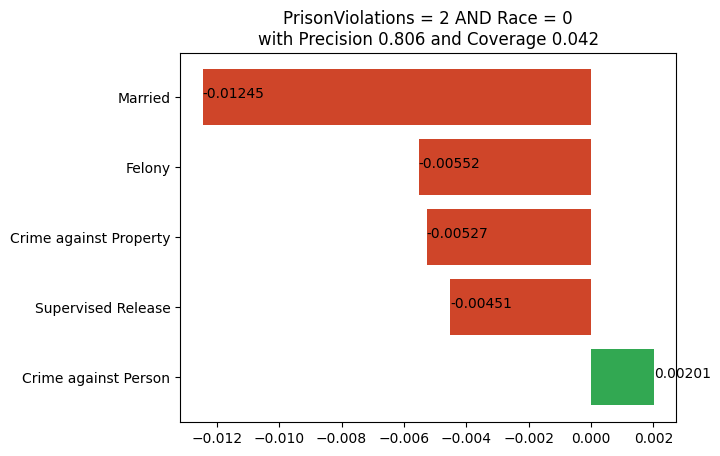

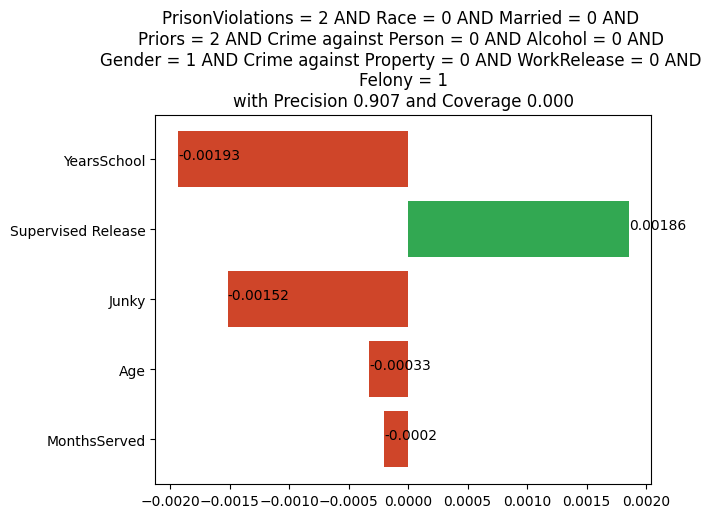

In [333]:
for t in [0.70, 0.80, 0.90]:
    new_lime(trg, dataset, threshold=t)
    img_file = 'img/%s/%05d-%03d.png' % (dataset_name, i, t * 100)
    plt.savefig(img_file, bbox_inches='tight')

In [332]:
anchor_original(trg, threshold=0.80)

Threshold:  0.80
Anchor:     PrisonViolations = 2 AND Married = 0
Precision:  0.83
Coverage:   0.06
